# Moedling for Tree-Shape by Central Attention CNN mixed with Inception using TF2

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import zipfile
z = zipfile.ZipFile("/content/drive/My Drive/wtit/wtit-20191028-336.zip")
z.extractall("")

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.keras.backend.clear_session()  # For easy reset of notebook state.
import numpy as np
import cv2
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,
                                     Input, BatchNormalization, GlobalAveragePooling2D, concatenate)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from time import time, ctime
from random import randint
import os

## Function

In [0]:
# prepare data, return data list and lable list
# c_max = 0 全抓; c_max > 0 依檔案修改時間正序取 c_max 個; c_max < 0 依檔案修改時間反序取 -c_max 個
def read_img(cats, paths, c_max=0, random_state=0): # Data preparation   
    X = []
    Y = []
    for i,c in enumerate(cats):
        ff = []
        lab = np.eye(len(cats))[i]
        ci = 0
        for p in paths:
            fs = glob(p + '/' + c + '/*.[jJ][pP][gG]') # image files may end with .jpg or .JPG
            if fs is not None:
                ff.extend(fs)
        ff = sorted(ff, key=os.path.getmtime)
        sz = len(ff) if c_max == 0 else abs(c_max)
        if random_state > 0:
            np.random.seed(random_state)
            order = np.random.choice(len(ff), sz, replace=False)
        else:
            order = range(sz) if c_max >= 0 else range(len(ff)-1, len(ff)-1-sz, -1)
        for i in order:
            img_bgr = cv2.imread(ff[i])
            img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_resz = cv2.resize(img, (RES,RES))
            img_reshape = np.reshape(img_resz, (RES,RES,3)) /255.
            
            X.append(img_reshape)
            Y.append(lab)
            ci += 1
            if c_max > 0 and ci >= c_max:
                break
        print(f'{SPECIES[c]} {c}:\t{ci}')
    return np.array(X), np.array(Y)

def generator2(X1, X2, y, batch_size):
    genX1 = datagen.flow(X1, y, batch_size=batch_size, seed=42)
    genX2 = datagen.flow(X2, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

def generator3(X1, X2, X3, y, batch_size):
    genX1 = datagen.flow(X1, y, batch_size=batch_size, seed=42)
    genX2 = datagen.flow(X2, y, batch_size=batch_size, seed=42)
    genX3 = datagen.flow(X3, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        X3i = genX3.next()
        yield [X1i[0], X2i[0], X3i[0]], X1i[1]

def plot_one(his, train, valid, step=5):
    his_train = []
    his_valid = []
    for x in his:
        his_train += x.history[train]
        his_valid += x.history[valid]
    plt.plot(his_train, label=train)
    plt.plot(his_valid, label=valid)
    plt.xticks(np.arange(0, len(train), step))
    plt.legend()
    plt.xlabel('epochs') #X軸文字
    plt.ylabel(train) #Y軸文字
    plt.grid() #劃格線

def plot_his(his):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plot_one(his, 'loss', 'val_loss')
    plt.subplot(1, 2, 2)
    plot_one(his, 'acc', 'val_acc')
    plt.show()

def evaluate(model, X, Y):
    loss, acc = model.evaluate(X, Y, verbose=0)
    print(f'accuracy: {acc:.4}, loss: {loss:.6}')
    pred = np.argmax(model.predict(X), axis=1)
    cm = confusion_matrix(np.argmax(Y, axis=1), pred)
    h = np.diag(cm) / np.sum(cm, axis=1)
    v = np.diag(cm) / np.sum(cm, axis=0)
    df = pd.DataFrame(cm, index=[f'[T]{SPECIES[x]}:{h[i]:.3}' for i, x in enumerate(CAT)],
                      columns=[f'[P]{SPECIES[x]}:{v[i]:.3}' for i, x in enumerate(CAT)])
    return df, pred

def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1),name=None, batch_normalization=False):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
 
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)
    if batch_normalization:
        x = BatchNormalization(axis=3,name=bn_name)(x)
    return x

def Inception(x, nb_filter):
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),name=None)
 
    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),name=None)
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1),name=None)
 
    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),name=None)
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(5,5), padding='same',strides=(1,1),name=None)
 
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1),name=None)
 
    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)
 
    return x

# Augumentation
datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180), 輕微讓樹幹傾斜
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images, 取消垂直翻轉
    zoom_range=0.5)

## Configuration

In [6]:
SPECIES = {'TM':'小葉欖仁', 'DR':'鳳凰木', 'BP':'構樹', 'LF':'楓香', 'FM':'榕樹', 'PI':'印度紫檀', 'TC':'大葉欖仁',
           'PC':'阿勃勒', 'BJ':'茄苳', 'PP':'盾柱木', 'AE':'青楓', 'MI':'白千層', 'KE':'臺灣欒樹', 'CO':'土肉桂',
           'AS':'黑板樹', 'FE':'印度橡膠樹', 'FF':'水同木', 'FS':'雀榕', 'MA':'苦楝', 'RR':'大王椰子', 'MP':'水黃皮',
           'LL':'大花紫薇', 'FR':'菩提', 'BU':'洋紫荊', 'BB':'艷紫荊', 'BB':'羊蹄甲', 'FG':'光臘樹', 'SS':'烏臼', 'FB':'垂榕',
           'FP':'稜果榕', 'CC':'樟樹', 'CB':'陰香', 'PF':'大葉山欖'}
CAT = ['TM', 'FM', 'KE', 'CC', 'BJ', 'LF', 'MI']
RES = 336
CA1_RATE = 2/3.
CA2_RATE = 1/2.
CA1_RES_F = int(RES*(1-CA1_RATE)/2)
CA2_RES_F = int(RES*(1-CA2_RATE)/2) 
print(f'{len(CAT)} categories are as below: {[(x, SPECIES[x]) for x in CAT]}')

7 categories are as below: [('TM', '小葉欖仁'), ('FM', '榕樹'), ('KE', '臺灣欒樹'), ('CC', '樟樹'), ('BJ', '茄苳'), ('LF', '楓香'), ('MI', '白千層')]


## Load training data

In [7]:
start = time()
TRAIN_PATH = ['wtit-20191028-336/train/tree']
X_train_, Y_train_ = read_img(CAT, TRAIN_PATH, -100)
X_train_ca1_ = X_train_[:, CA1_RES_F:RES-CA1_RES_F, CA1_RES_F:RES-CA1_RES_F]
X_train_ca2_ = X_train_[:, CA2_RES_F:RES-CA2_RES_F, CA2_RES_F:RES-CA2_RES_F]
print(f'[{len(X_train_)}] training data loaded for {time()-start:.2f} secs')

# split validatition data
X_train, X_valid, X_train_ca1, X_valid_ca1, X_train_ca2, X_valid_ca2, Y_train, Y_valid = \
    train_test_split(X_train_, X_train_ca1_, X_train_ca2_, Y_train_, test_size=0.2, random_state=42)

小葉欖仁 TM:	100
榕樹 FM:	100
臺灣欒樹 KE:	100
樟樹 CC:	100
茄苳 BJ:	100
楓香 LF:	100
白千層 MI:	100
[700] training data loaded for 4.89 secs


## Show training data

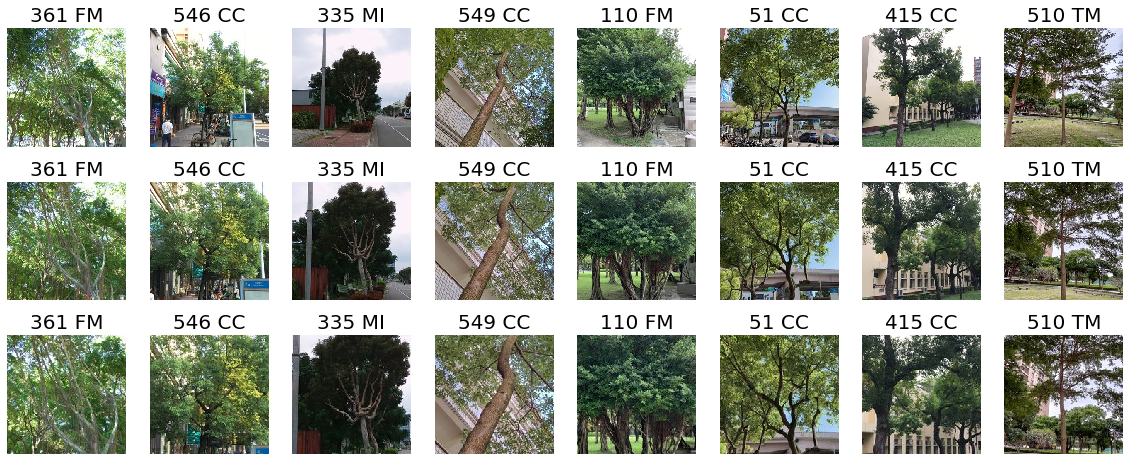

In [0]:
plt.subplots(figsize=(20,8))
W = 8 # sample size, only a row
DRAW_X = [X_train, X_train_ca1, X_train_ca2] # target vector for plot
DRAW_Y = Y_train
for i in range(W):
    idx = randint(0, len(DRAW_X[0])-1)
    cat = CAT[np.argmax(DRAW_Y[idx])]
    t = f'{idx} {cat}'
    for j, d in enumerate(DRAW_X):
        plt.subplot(3, W, i+(j*W)+1)
        plt.axis('off')
        plt.title(t, fontproperties='SimSun', fontsize=20)
        plt.imshow(d[idx])

## Load testing data

In [8]:
start = time()
TEST_PATH = ['wtit-20191028-336/test/tree']
X_test, Y_test = read_img(CAT, TEST_PATH, 15)
X_test_ca1 = X_test[:, CA1_RES_F:RES-CA1_RES_F, CA1_RES_F:RES-CA1_RES_F]
X_test_ca2 = X_test[:, CA2_RES_F:RES-CA2_RES_F, CA2_RES_F:RES-CA2_RES_F]
print(f'[{len(X_test)}] test data loaded for {time()-start:.2f} secs')

小葉欖仁 TM:	15
榕樹 FM:	15
臺灣欒樹 KE:	15
樟樹 CC:	15
茄苳 BJ:	15
楓香 LF:	15
白千層 MI:	15
[105] test data loaded for 0.48 secs


## Show testing data

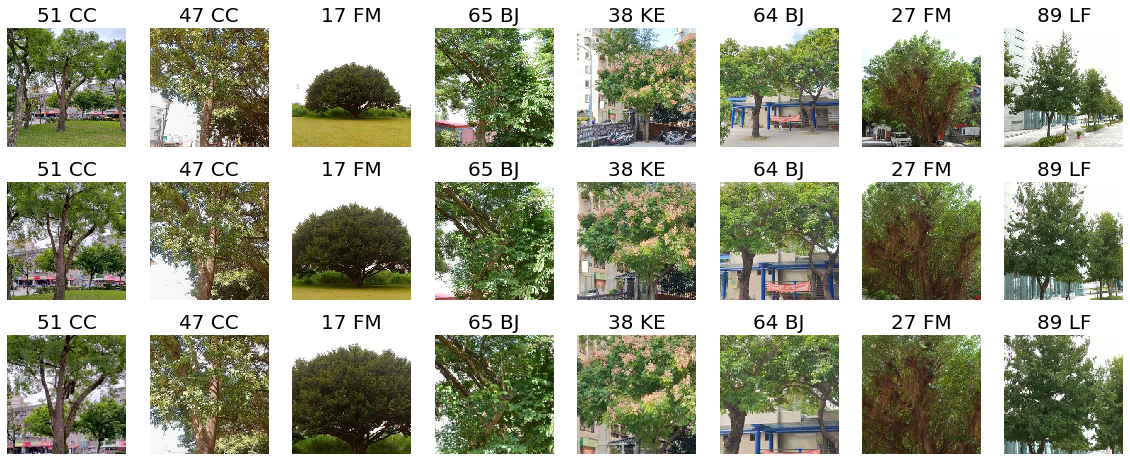

In [0]:
plt.subplots(figsize=(20,8))
W = 8 # sample size, only a row
DRAW_X = [X_test, X_test_ca1, X_test_ca2] # target vector for plot
DRAW_Y = Y_test
for i in range(W):
    idx = randint(0, len(DRAW_X[0])-1)
    cat = CAT[np.argmax(DRAW_Y[idx])]
    t = f'{idx} {cat}'
    for j, d in enumerate(DRAW_X):
        plt.subplot(3, W, i+(j*W)+1)
        plt.axis('off')
        plt.title(t, fontproperties='SimSun', fontsize=20)
        plt.imshow(d[idx])

## Model design - STD + Central Attention 1/2



In [0]:
in_std = Input(shape=(RES,RES,3))
x = Inception(in_std, 24)
x = Inception(x, 48)
x = Inception(x, 96)
x = GlobalAveragePooling2D()(x)

in_ca2 = Input(shape=(int(RES*CA2_RATE),int(RES*CA2_RATE),3))
w = Conv2D(filters=24, kernel_size=(3,3), activation='relu', padding='same')(in_ca2)
w = Conv2D(filters=48, kernel_size=(3,3), activation='relu', padding='same')(w)
w = MaxPooling2D(pool_size=(2, 2))(w)
w = Conv2D(filters=48, kernel_size=(3,3), activation='relu', padding='same')(w)
w = Conv2D(filters=96, kernel_size=(3,3), activation='relu', padding='same')(w)
w = GlobalAveragePooling2D()(w)

z = concatenate([x , w])
z = BatchNormalization()(z)
z = Dense(2048, activation='relu')(z)
z = Dropout(0.5)(z)
outputs = Dense(len(CAT), activation='softmax')(z)

model = Model(inputs=[in_std, in_ca2], outputs=outputs)
model.summary()

# Model configuration
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
his = []

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 336, 336, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 336, 336, 24) 96          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 336, 336, 24) 96          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 336, 336, 3)  0           input_1[0][0]                    
_____________

In [0]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/wtit/model/wtit-tree-cacnn_inception_mixed-stdca2-cat7-ep{epoch:03d}-valacc{val_acc:.3f}.h5', monitor='val_acc',
                             save_weights_only=False, save_best_only=True, period=1, verbose=0)
earlystop = EarlyStopping(monitor='val_acc', patience=15)
model_history = model.fit_generator(generator2(X_train, X_train_ca2, Y_train, batch_size=8),
                                    steps_per_epoch=400, epochs=600, callbacks=[checkpoint, earlystop],
                                    validation_data=([X_valid, X_valid_ca2], Y_valid))
his.append(model_history)
plot_his(his)

Epoch 1/600
400/400 [==============================] - 1102s 3s/step - loss: 1.9215 - acc: 0.2094 - val_loss: 1.8565 - val_acc: 0.2500
Epoch 2/600
400/400 [==============================] - 1072s 3s/step - loss: 1.8304 - acc: 0.2663 - val_loss: 2.8443 - val_acc: 0.1571
Epoch 3/600
400/400 [==============================] - 1067s 3s/step - loss: 1.7477 - acc: 0.3128 - val_loss: 1.9863 - val_acc: 0.2571
Epoch 4/600
400/400 [==============================] - 1068s 3s/step - loss: 1.6784 - acc: 0.3391 - val_loss: 4.6750 - val_acc: 0.1500
Epoch 5/600
400/400 [==============================] - 1063s 3s/step - loss: 1.6251 - acc: 0.3691 - val_loss: 3.1664 - val_acc: 0.2429
Epoch 6/600
400/400 [==============================] - 1063s 3s/step - loss: 1.5675 - acc: 0.3916 - val_loss: 2.6867 - val_acc: 0.2429
Epoch 7/600
400/400 [==============================] - 1063s 3s/step - loss: 1.5437 - acc: 0.3931 - val_loss: 2.2442 - val_acc: 0.3429
Epoch 8/600
400/400 [==============================] - 

In [10]:
model = load_model('/content/drive/My Drive/wtit/model/wtit-tree-cacnn_inception_mixed-stdca2-cat7-ep027-valacc0.536.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/wtit/model/wtit-tree-cacnn_inception_mixed_cont-stdca2-cat7-ep{epoch:03d}-valacc{val_acc:.3f}.h5', monitor='val_acc',
                             save_weights_only=False, save_best_only=False, period=1, verbose=0)
earlystop = EarlyStopping(monitor='val_acc', patience=15)
model_history = model.fit_generator(generator2(X_train, X_train_ca2, Y_train, batch_size=8),
                                    steps_per_epoch=400, epochs=600, callbacks=[checkpoint, earlystop],
                                    validation_data=([X_valid, X_valid_ca2], Y_valid))
his.append(model_history)
plot_his(his)

Epoch 1/600
140/400 [=========>....................] - ETA: 26s - loss: 1.5908 - acc: 0.5929

OSError: ignored

In [12]:
cm, Y_pred = evaluate(model, [X_test, X_test_ca2], Y_test)
cm

ResourceExhaustedError: ignored

In [0]:
model_chk = load_model('/content/drive/My Drive/wtit/model/wtit-tree-cacnn_inception-stdca2-cat7-ep028-valacc0.550.h5')
cm, Y_pred = evaluate(model_chk, [X_test, X_test_ca2], Y_test)
cm

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
accuracy: 0.419, loss: 4.1434


[P]小葉欖仁:0.556  [P]榕樹:0.583  ...  [P]楓香:0.295  [P]白千層:0.462
[T]小葉欖仁:0.333              5            1  ...            5             2
[T]榕樹:0.467                0            7  ...            2             1
[T]臺灣欒樹:0.4                0            2  ...            3             3
[T]樟樹:0.0667               1            1  ...            6             1
[T]茄苳:0.4                  1            1  ...            6             0
[T]楓香:0.867                2            0  ...           13             0
[T]白千層:0.4                 0            0  ...            9             6

[7 rows x 7 columns]

## Show misclassified image

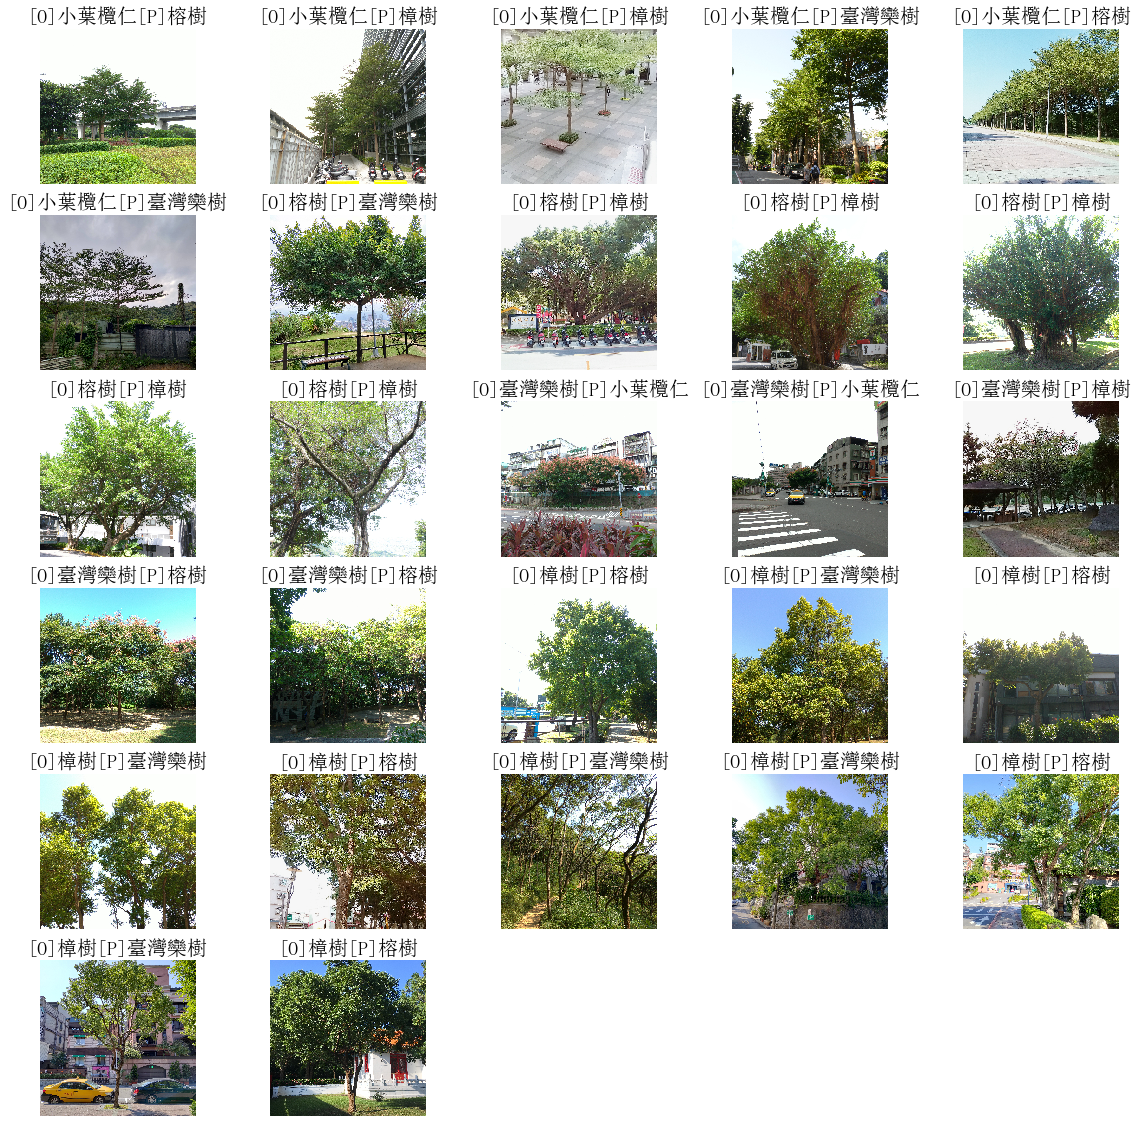

In [0]:
idx = np.where(Y_pred != np.argmax(Y_test, axis=1))[0]
false_img = X_test[idx]
false_answer = np.argmax(Y_test, axis=1)[idx]
false_pre = Y_pred[idx]

width = 5
height = len(false_img) // width + 1# // 取商
plt.figure(figsize=(20,20))
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    t = f'[O]{SPECIES[CAT[false_answer[i]]]}[P]{SPECIES[CAT[false_pre[i]]]}'
    plt.title(t, fontproperties='SimSun', fontsize=20)
    plt.axis('off')
    plt.imshow(img)